<a href="https://colab.research.google.com/github/UtwoA/Introduction_to_ML/blob/main/ml7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
class NeuralNetwork:

    def __init__(self, layers, learning_rate=0.01, seed=42):
        self.layers = layers
        self.lr = learning_rate
        self.seed = seed
        self.weights = {}
        self.cache = {}
        self.grads = {}
        self.loss_history = []

        np.random.seed(self.seed)
        for l in range(1, len(layers)):
            self.weights[f'W{l}'] = np.random.randn(layers[l], layers[l-1]) * 0.1
            self.weights[f'b{l}'] = np.zeros((layers[l], 1))

    def _sigmoid(self, z):
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def _relu(self, z):
        return np.maximum(0, z)

    def _sigmoid_derivative(self, z):
        s = self._sigmoid(z)
        return s * (1 - s)

    def _relu_derivative(self, z):
        return (z > 0).astype(float)

    def forward(self, X):
        self.cache['A0'] = X
        L = len(self.weights) // 2

        for l in range(1, L):
            Z = self.weights[f'W{l}'] @ self.cache[f'A{l-1}'] + self.weights[f'b{l}']
            self.cache[f'Z{l}'] = Z
            self.cache[f'A{l}'] = self._relu(Z)

        ZL = self.weights[f'W{L}'] @ self.cache[f'A{L-1}'] + self.weights[f'b{L}']
        self.cache[f'Z{L}'] = ZL
        self.cache[f'A{L}'] = self._sigmoid(ZL)
        return self.cache[f'A{L}']

    def compute_cost(self, AL, Y):
        m = Y.shape[1]
        cost = -np.sum(Y * np.log(AL + 1e-8) + (1 - Y) * np.log(1 - AL + 1e-8)) / m
        return np.squeeze(cost)

    def backward(self, AL, Y):
        m = Y.shape[1]
        L = len(self.weights) // 2

        dAL = -(Y / (AL + 1e-8) - (1 - Y) / (1 - AL + 1e-8))
        dZ = dAL * self._sigmoid_derivative(self.cache[f'Z{L}'])

        self.grads[f'dW{L}'] = dZ @ self.cache[f'A{L-1}'].T / m
        self.grads[f'db{L}'] = np.sum(dZ, axis=1, keepdims=True) / m

        for l in reversed(range(1, L)):
            dA_prev = self.weights[f'W{l+1}'].T @ dZ
            dZ = dA_prev * self._relu_derivative(self.cache[f'Z{l}'])
            self.grads[f'dW{l}'] = dZ @ self.cache[f'A{l-1}'].T / m
            self.grads[f'db{l}'] = np.sum(dZ, axis=1, keepdims=True) / m

    def update_weights(self):
        L = len(self.weights) // 2
        for l in range(1, L+1):
            self.weights[f'W{l}'] -= self.lr * self.grads[f'dW{l}']
            self.weights[f'b{l}'] -= self.lr * self.grads[f'db{l}']

    def train_sgd(self, X, Y, epochs=1000, batch_size=32, verbose=True):
        m = X.shape[1]
        for epoch in range(epochs):
            perm = np.random.permutation(m)
            X_shuffled = X[:, perm]
            Y_shuffled = Y[:, perm]

            epoch_loss = 0
            num_batches = 0

            for i in range(0, m, batch_size):
                end = min(i + batch_size, m)
                X_batch = X_shuffled[:, i:end]
                Y_batch = Y_shuffled[:, i:end]

                AL = self.forward(X_batch)
                loss = self.compute_cost(AL, Y_batch)
                epoch_loss += loss
                num_batches += 1

                self.backward(AL, Y_batch)
                self.update_weights()

            avg_loss = epoch_loss / num_batches
            self.loss_history.append(avg_loss)

            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

    def predict(self, X, threshold=0.5):
        probs = self.forward(X)
        return (probs > threshold).astype(int)

    def predict_proba(self, X):
        return self.forward(X)

In [3]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_acc = accuracy_score(y_train.flatten(), y_pred_train.flatten())
    test_acc = accuracy_score(y_test.flatten(), y_pred_test.flatten())

    print("\n" + "="*50)
    print("РЕЗУЛЬТАТЫ ОБУЧЕНИЯ")
    print("="*50)
    print(f"Точность на обучающей выборке: {train_acc:.4f}")
    print(f"Точность на тестовой выборке: {test_acc:.4f}")

    print("\nДетальный отчет по классификации (тест):")
    print(classification_report(y_test.flatten(), y_pred_test.flatten()))

    cm = confusion_matrix(y_test.flatten(), y_pred_test.flatten())
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return train_acc, test_acc


def plot_training_history(model):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(model.loss_history)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1,2,2)
    window = max(1, len(model.loss_history)//50)
    smooth_loss = np.convolve(model.loss_history, np.ones(window)/window, mode='valid')
    plt.plot(smooth_loss)
    plt.title('Smoothed Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [4]:
def experiment_architectures(X_train, y_train, X_test, y_test):
    architectures = [
        [X_train.shape[0], 8, 4, 1],
        [X_train.shape[0], 16, 8, 4, 1],
        [X_train.shape[0], 32, 16, 8, 4, 1],
        [X_train.shape[0], 64, 32, 16, 8, 4, 1]
    ]

    results = []

    for idx, arch in enumerate(architectures, 1):
        print(f"\n{'='*60}\nARCHITECTURE {idx}: {arch}\n{'='*60}")
        model = NeuralNetwork(layers=arch, learning_rate=0.01)
        model.train_sgd(X_train, y_train, epochs=500, batch_size=16, verbose=False)

        train_acc, test_acc = evaluate_model(model, X_train, y_train, X_test, y_test)
        results.append({
            'architecture': arch,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'num_layers': len(arch)-1,
            'model': model
        })

        plot_training_history(model)

    print("\n" + "="*80)
    print("СРАВНЕНИЕ АРХИТЕКТУР")
    print("="*80)

    df = pd.DataFrame(results)
    print(df[['architecture','train_accuracy','test_accuracy','num_layers']].round(4))

    plt.figure(figsize=(10,6))
    x_pos = np.arange(len(results))
    width = 0.35
    plt.bar(x_pos - width/2, [r['train_accuracy'] for r in results], width, alpha=0.7, label='Train')
    plt.bar(x_pos + width/2, [r['test_accuracy'] for r in results], width, alpha=0.7, label='Test')
    plt.xlabel('Architecture')
    plt.ylabel('Accuracy')
    plt.title('Train vs Test Accuracy')
    plt.xticks(x_pos, [f'Arch {i+1}' for i in range(len(results))])
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return results

In [6]:
file_path = "diabetes.txt"
data = pd.read_csv(file_path, sep='\t', encoding='cp1251')

print("Data Info:")
print(f"Shape: {data.shape}")
print(f"Columns: {list(data.columns)}")
print(f"\nFirst 5 rows:\n{data.head()}")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

unique_classes = np.unique(y)
print(f"\nUnique classes: {unique_classes}")

if len(unique_classes) > 2:
    print("Converting to binary classification...")
    y = (y > np.median(y)).astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X = X_scaled.T
y = y.reshape(1, -1)

X_train, X_test, y_train, y_test = train_test_split(X.T, y.T, test_size=0.2, random_state=42, stratify=y.T)
X_train, X_test = X_train.T, X_test.T
y_train, y_test = y_train.T, y_test.T

print(f"\nShapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Data Info:
Shape: (768, 9)
Columns: ['Беременность', 'Глюкоза', 'АД', 'Толщина КС', 'Инсулин', 'ИМТ', 'Наследственность', 'Возраст', 'Диагноз']

First 5 rows:
   Беременность  Глюкоза  АД  Толщина КС  Инсулин   ИМТ  Наследственность  \
0             6      148  72        35.0      0.0  33.6             0.627   
1             1       85  66        29.0      0.0  26.6             0.351   
2             8      183  64         0.0      0.0  23.3             0.672   
3             1       89  66        23.0     94.0  28.1             0.167   
4             0      137  40        35.0    168.0  43.1             2.288   

   Возраст  Диагноз  
0       50        1  
1       31        0  
2       32        1  
3       21        0  
4       33        1  

Unique classes: [0 1]

Shapes:
X_train: (8, 614), y_train: (1, 614)
X_test: (8, 154), y_test: (1, 154)



ARCHITECTURE 1: [8, 8, 4, 1]

РЕЗУЛЬТАТЫ ОБУЧЕНИЯ
Точность на обучающей выборке: 0.8029
Точность на тестовой выборке: 0.7468

Детальный отчет по классификации (тест):
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       100
           1       0.65      0.61      0.63        54

    accuracy                           0.75       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.74      0.75      0.75       154



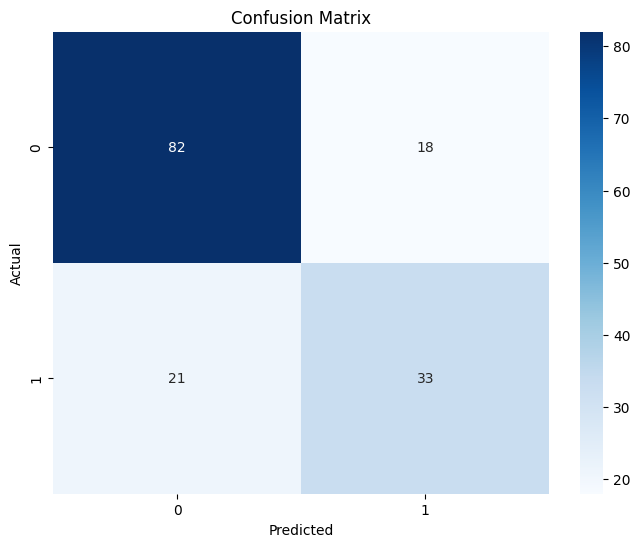

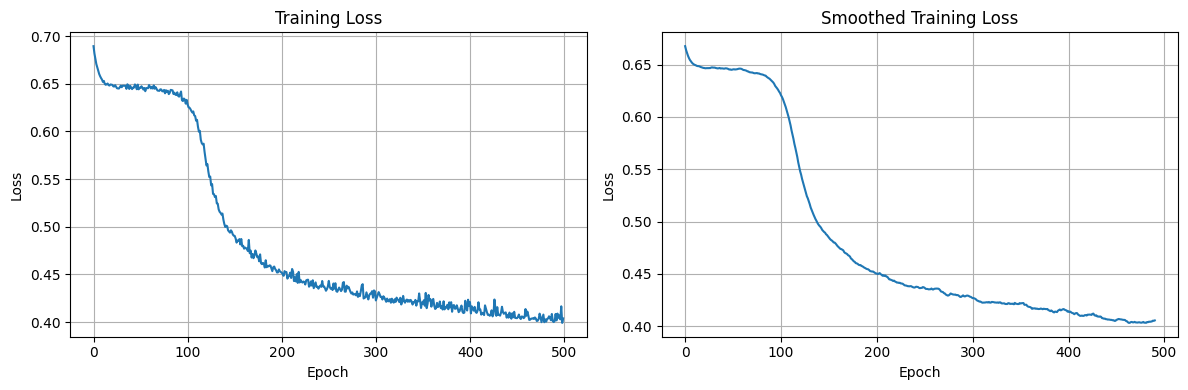


ARCHITECTURE 2: [8, 16, 8, 4, 1]

РЕЗУЛЬТАТЫ ОБУЧЕНИЯ
Точность на обучающей выборке: 0.8322
Точность на тестовой выборке: 0.7273

Детальный отчет по классификации (тест):
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       100
           1       0.62      0.56      0.59        54

    accuracy                           0.73       154
   macro avg       0.70      0.69      0.69       154
weighted avg       0.72      0.73      0.72       154



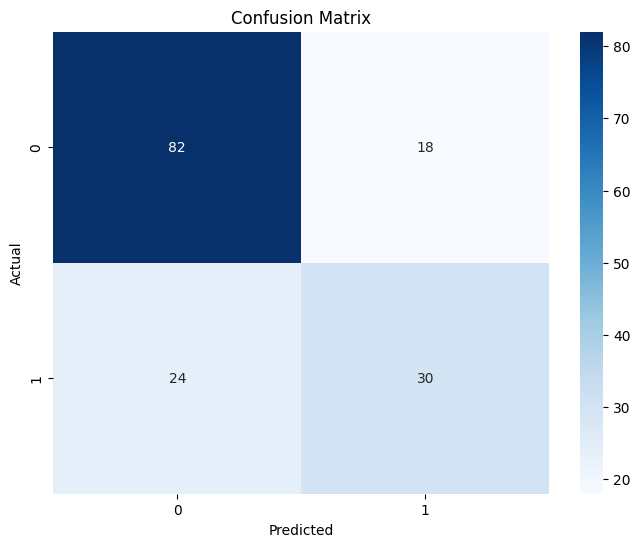

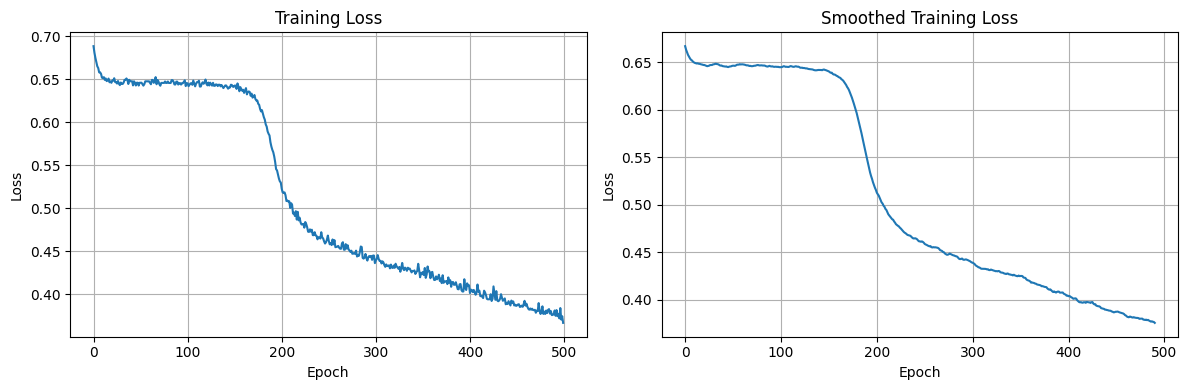


ARCHITECTURE 3: [8, 32, 16, 8, 4, 1]

РЕЗУЛЬТАТЫ ОБУЧЕНИЯ
Точность на обучающей выборке: 0.8860
Точность на тестовой выборке: 0.7013

Детальный отчет по классификации (тест):
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       100
           1       0.60      0.46      0.52        54

    accuracy                           0.70       154
   macro avg       0.67      0.65      0.65       154
weighted avg       0.69      0.70      0.69       154



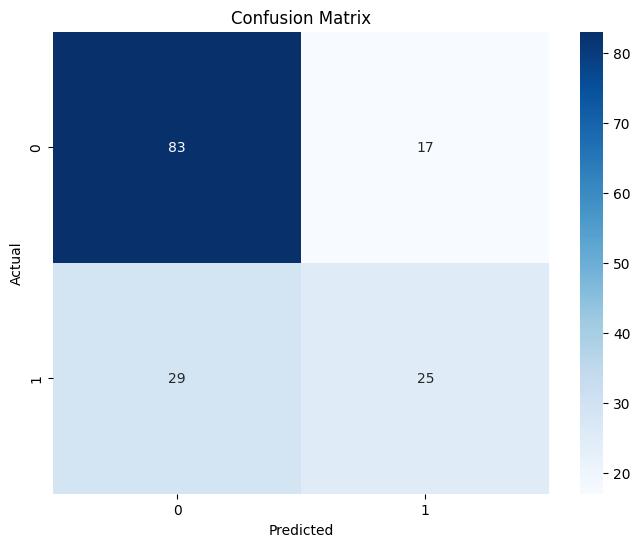

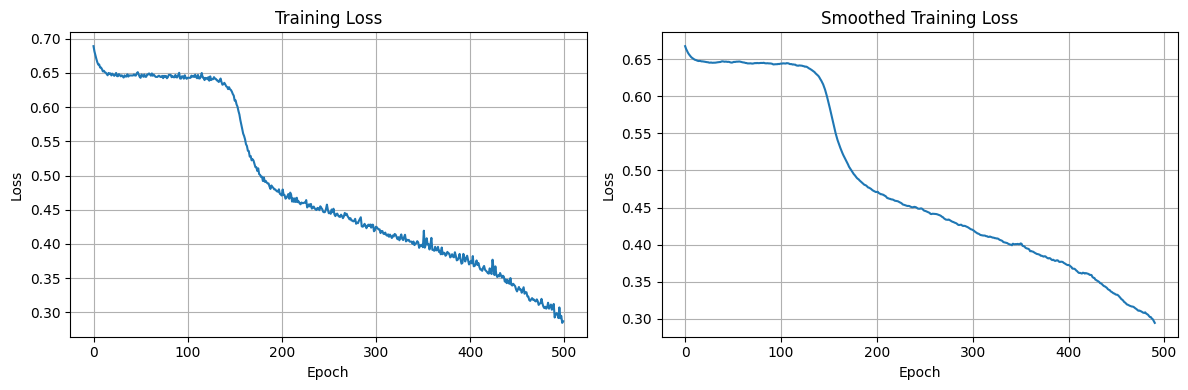


ARCHITECTURE 4: [8, 64, 32, 16, 8, 4, 1]

РЕЗУЛЬТАТЫ ОБУЧЕНИЯ
Точность на обучающей выборке: 0.9088
Точность на тестовой выборке: 0.6948

Детальный отчет по классификации (тест):
              precision    recall  f1-score   support

           0       0.72      0.86      0.79       100
           1       0.60      0.39      0.47        54

    accuracy                           0.69       154
   macro avg       0.66      0.62      0.63       154
weighted avg       0.68      0.69      0.68       154



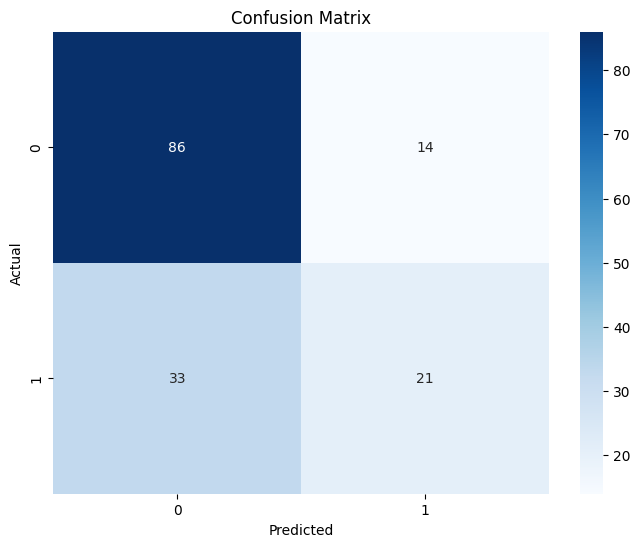

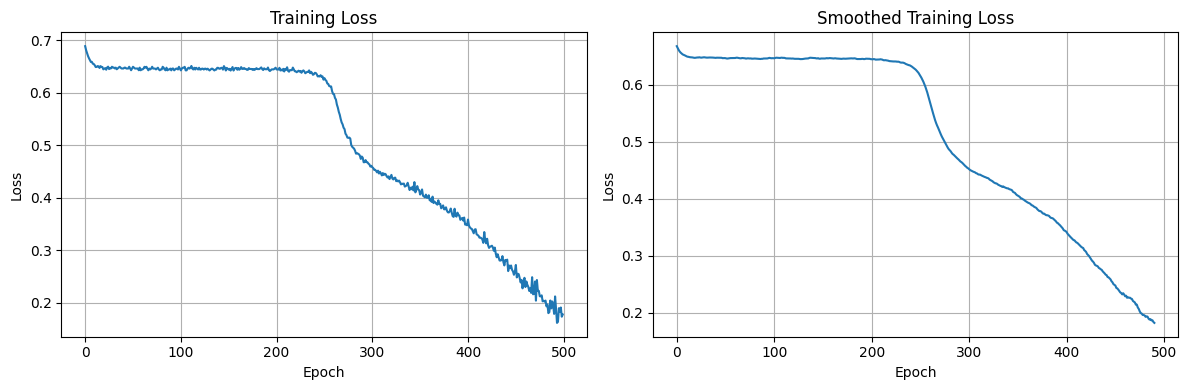


СРАВНЕНИЕ АРХИТЕКТУР
               architecture  train_accuracy  test_accuracy  num_layers
0              [8, 8, 4, 1]          0.8029         0.7468           3
1          [8, 16, 8, 4, 1]          0.8322         0.7273           4
2      [8, 32, 16, 8, 4, 1]          0.8860         0.7013           5
3  [8, 64, 32, 16, 8, 4, 1]          0.9088         0.6948           6


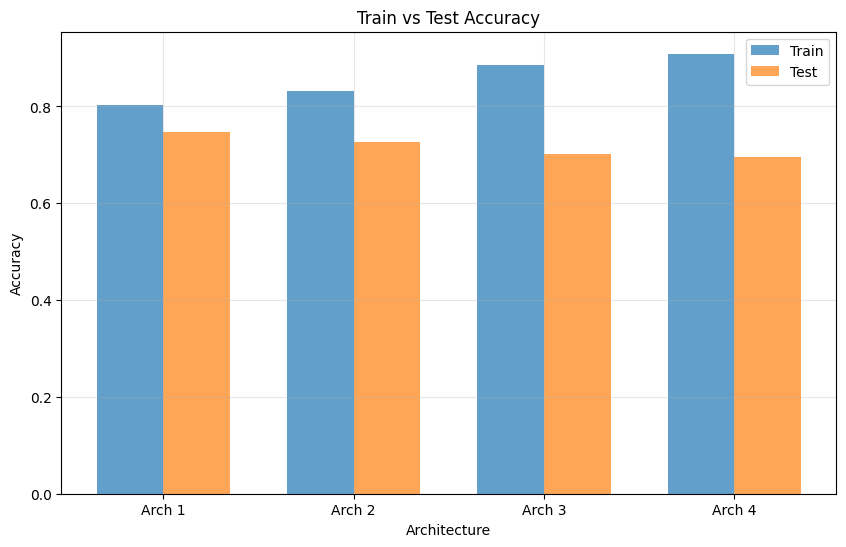


BEST ARCHITECTURE:
Layers: [8, 8, 4, 1]
Test Accuracy: 0.7468

Sample predictions:
First 10 probabilities: [0.88249779 0.58546621 0.25626835 0.5292831  0.00106839 0.24760689
 0.55251536 0.92691491 0.03786597 0.78140363]
First 10 true labels: [0 0 0 1 0 0 1 1 0 0]

Weights analysis:
W1: shape=(8, 8), mean=-0.0452, std=0.2713
W2: shape=(4, 8), mean=0.0800, std=0.3800
W3: shape=(1, 4), mean=-0.3091, std=1.0650


In [7]:
results = experiment_architectures(X_train, y_train, X_test, y_test)

best = max(results, key=lambda x: x['test_accuracy'])
print(f"\n{'='*60}\nBEST ARCHITECTURE:\nLayers: {best['architecture']}\nTest Accuracy: {best['test_accuracy']:.4f}\n{'='*60}")

best_model = best['model']
y_proba = best_model.predict_proba(X_test)
print(f"\nSample predictions:")
print(f"First 10 probabilities: {y_proba.flatten()[:10]}")
print(f"First 10 true labels: {y_test.flatten()[:10]}")

print("\nWeights analysis:")
for k, v in best_model.weights.items():
    if 'W' in k:
        print(f"{k}: shape={v.shape}, mean={np.mean(v):.4f}, std={np.std(v):.4f}")